In [106]:
!pip install mne
!pip install pyxdf
!pip install PyWavelets
!pip install pandas 
!pip install seaborn

from tqdm import tqdm
import pyxdf
import mne
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from copy import deepcopy
from matplotlib import pyplot
import matplotlib.pyplot as plt 
from mne.decoding import Scaler
import copy
import pathlib
from pathlib import Path
from typing import Dict, List, Optional, Union
from tqdm.auto import tqdm
# import plotly.graph_objects as go
# import plotly.subplots as sp
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import argparse

%load_ext autoreload
%autoreload 2


from utils_clean import show_streams, find_stream, get_duration, get_time_series, set_channel_names, plot_channel_correlation,detect_bad_channels,plot_bads, ica_analysis,remove_breaks,build_class_epochs_mne,create_dataset,return_dataset,plot_topo,plot_eeg,plot_evoked,standartization
# from preprocessing_1 import Preprocessing

python(41887) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


python(41888) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


python(41889) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


python(41890) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


python(41891) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## **Load Data**

In [113]:
# session_name = "S01"


# base_path = "/Users/arnavkapur/Desktop/EEG_Speech"
# data_path = os.path.join(base_path, "DATA","RAW")

# xdf_file_path = os.path.join(data_path, f"{session_name}.xdf")

xdf_file_path = "/Users/arnavkapur/Desktop/EEG_Speech/DATA/sub-P001_ses-S001_task-Default_run-001_eeg_old33.xdf"
# Load the .xdf file
data, header = pyxdf.load_xdf(xdf_file_path)
print(f"Successfully loaded data from {xdf_file_path}")

mark_path = ("/Users/arnavkapur/Desktop/EEG_Speech/DATA/marker/")
# mark_session = os.path.join(mark_path, f"{session_name}.csv")
# mark = pd.read_csv(mark_session)


Successfully loaded data from /Users/arnavkapur/Desktop/EEG_Speech/DATA/sub-P001_ses-S001_task-Default_run-001_eeg_old33.xdf


In [114]:
# name = session_name
show_streams(data)
eeg_stream = find_stream('eeg', data)
marker_stream = find_stream('marker', data)
df_marker = get_time_series(marker_stream)
sfreq = float(eeg_stream["info"]["nominal_srate"][0])


Channel 0:
Effective Rate: 25.211311780485705
Start TimeStamp: 
Channel Name: ['ACC_Z']
Channel Type: ['AccelerometerZ']
Time Series Shape: (33091, 1)
--------------------
Channel 1:
Effective Rate: 100.00000010687774
Start TimeStamp: 
Channel Name: ['E7240457_MEMsAll']
Channel Type: ['MEMsAll']
Time Series Shape: (131110, 9)
--------------------
Channel 2:
Effective Rate: 1000.0000010872761
Start TimeStamp: 
Channel Name: ['E7240457_EEG']
Channel Type: ['EEG']
Time Series Shape: (1311090, 64)
--------------------
Channel 3:
Effective Rate: 0
Start TimeStamp: 
Channel Name: ['pupil_capture']
Channel Type: ['Gaze']
Time Series Shape: (321297, 22)
--------------------
Channel 4:
Effective Rate: 15.001400119942048
Start TimeStamp: 
Channel Name: ['EDA']
Channel Type: ['EDA']
Time Series Shape: (19690, 1)
--------------------
Channel 5:
Effective Rate: 0
Start TimeStamp: 
Channel Name: ['SCR_RIS']
Channel Type: ['SCRRiseTime']
Time Series Shape: (311, 1)
--------------------
Channel 6:
Eff

In [115]:
## Identify channel position for Neurable headset

channels_info = data[3]['info']['desc'][0]['channels'][0]['channel']

# Extract labels from each channel
ch_names = [channel['label'][0] for channel in channels_info]
print(len(ch_names))
print(ch_names)


22
['confidence', 'norm_pos_x', 'norm_pos_y', 'gaze_point_3d_x', 'gaze_point_3d_y', 'gaze_point_3d_z', 'eye_center0_3d_x', 'eye_center0_3d_y', 'eye_center0_3d_z', 'eye_center1_3d_x', 'eye_center1_3d_y', 'eye_center1_3d_z', 'gaze_normal0_x', 'gaze_normal0_y', 'gaze_normal0_z', 'gaze_normal1_x', 'gaze_normal1_y', 'gaze_normal1_z', 'diameter0_2d', 'diameter1_2d', 'diameter0_3d', 'diameter1_3d']


In [116]:
"""Create MNE file raw containing the EEG Stream"""

eeg_data = eeg_stream["time_series"].T
eeg_data = eeg_data[:64]
print(eeg_data.shape)
sfreq = float(eeg_stream["info"]["nominal_srate"][0])
eeg_info = mne.create_info(64, sfreq, ["eeg"]*64)
raw = mne.io.RawArray(eeg_data, eeg_info)
# review information
ssp_projectors = raw.info["projs"]
raw.del_proj()

(64, 1311090)
Creating RawArray with float64 data, n_channels=64, n_times=1311090
    Range : 0 ... 1311089 =      0.000 ...  1311.089 secs
Ready.


<RawArray | 64 x 1311090 (1311.1 s), ~640.2 MB, data loaded>

Shape of EEG data: (64, 3328000)
EEG data size: 1703936000 bytes (1625.00 MB)


## **Filtering**

In [117]:

raw_highpass = raw.copy().filter(l_freq=1, h_freq=None)
raw_lowpass = raw_highpass.filter(l_freq=None, h_freq=100)
raw_notch = raw_lowpass.notch_filter(freqs=[60, 120,180])
raw_filtered = raw_notch.copy()

raw_filtered.get_data().shape



Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.4s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 133 samples (0.133 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.3s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.4s


(64, 1311090)

Error: The number of channel names does not match the number of channels in the data.


<Figure size 640x480 with 0 Axes>

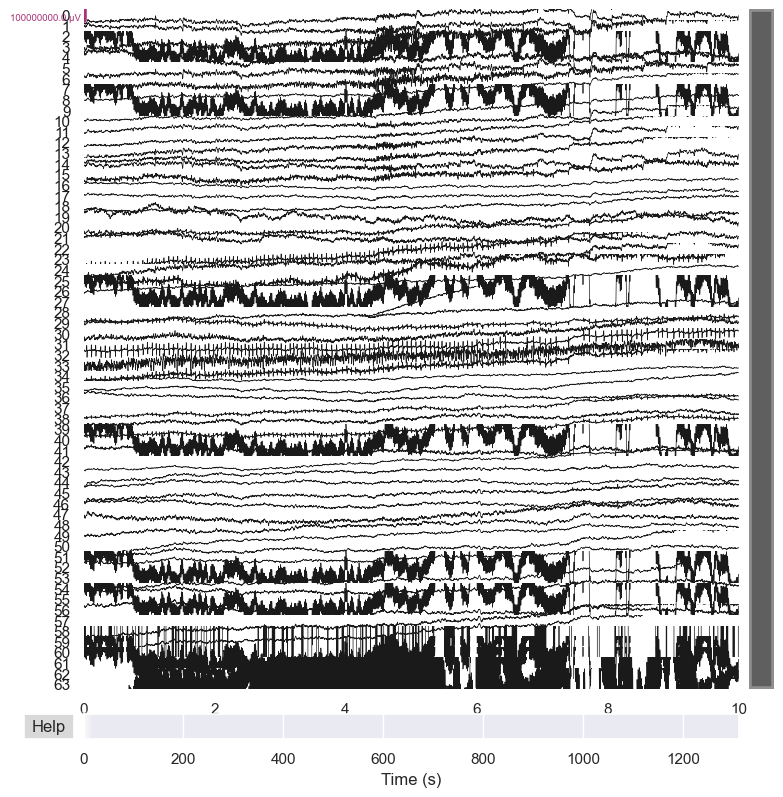

In [118]:
# Plot Raw EEG Data
plt.clf()
set_channel_names(raw,ch_names)
raw.plot(start=0, n_channels=64, scalings = {"eeg": 50})
# raw.plot(start=0, n_channels=64, scalings = "auto")

plt.show()



Error: The number of channel names does not match the number of channels in the data.


<Figure size 640x480 with 0 Axes>

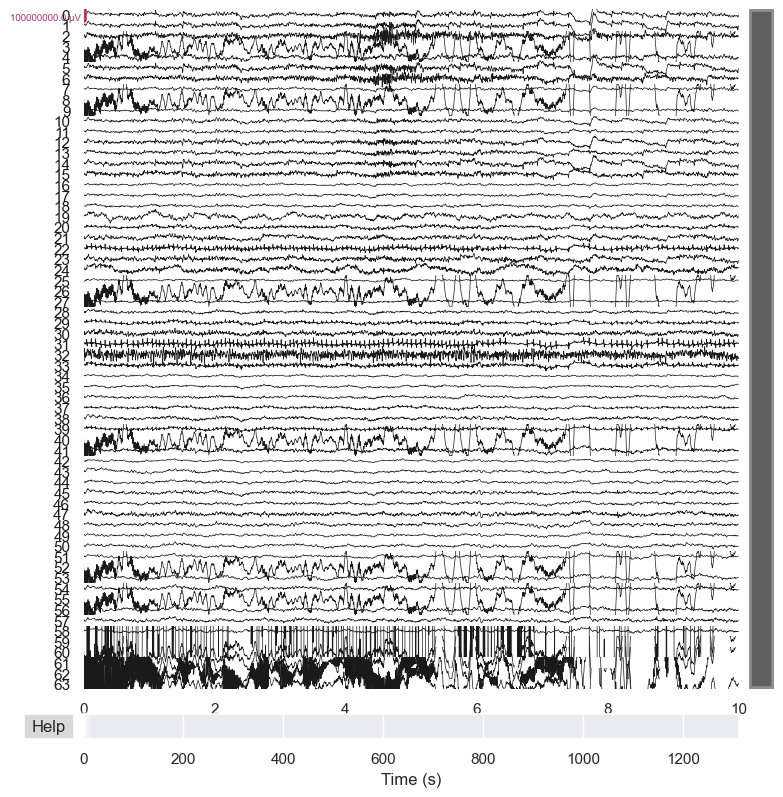

In [120]:
plt.clf()
set_channel_names(raw,ch_names)
raw_filtered.plot(start=0, n_channels=64, scalings = {"eeg": 50})
# raw.plot(start=0, n_channels=64, scalings = "auto")

plt.show()

Effective window size : 2.048 (s)
Plotting power spectral density (dB=True).


/var/folders/w2/bjrs7bh539701pd5yx65p_cc0000gp/T/ipykernel_4819/4098532110.py:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  fig = raw.compute_psd(tmax=np.inf, fmax=250).plot()
/Users/arnavkapur/.pyenv/versions/3.10.12/lib/python3.10/site-packages/mne/viz/utils.py:158: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


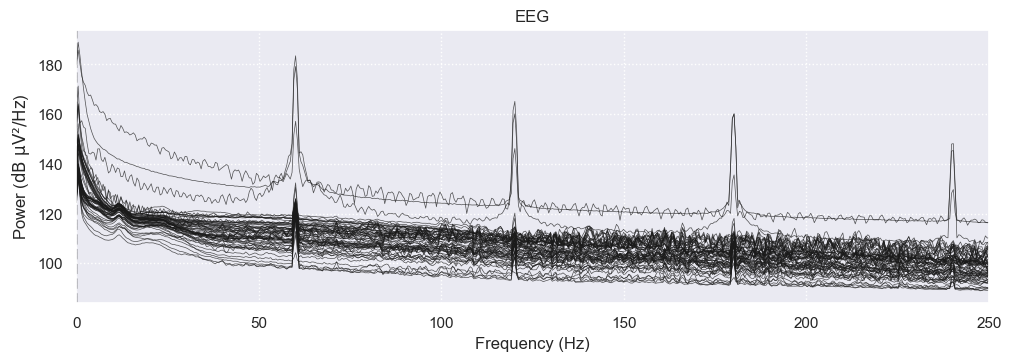

In [ ]:
#  Check PSD
fig = raw.compute_psd(tmax=np.inf, fmax=250).plot()
plt.show()
# 

New channel names: ['Fpz', 'Fp1', 'Fp2', 'AF3', 'AF4', 'AF7', 'AF8', 'Fz', 'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'FCz', 'FC1', 'FC2', 'FC3', 'FC4', 'FC5', 'FC6', 'FT7', 'FT8', 'Cz', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'T7', 'T8', 'CP1', 'CP2', 'CP3', 'CP4', 'CP5', 'CP6', 'TP7', 'TP8', 'Pz', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'POz', 'PO3', 'PO4', 'PO5', 'PO6', 'PO7', 'PO8', 'Oz', 'O1', 'O2', 'ECG', 'HEOR', 'HEOL', 'VEOU', 'VEOL']


/var/folders/w2/bjrs7bh539701pd5yx65p_cc0000gp/T/ipykernel_4819/1626480345.py:8: RuntimeWarning: DigMontage is only a subset of info. There are 5 channel positions not present in the DigMontage. The channels missing from the montage are:

['ECG', 'HEOR', 'HEOL', 'VEOU', 'VEOL'].

Consider using inst.rename_channels to match the montage nomenclature, or inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses.
  raw_filtered.set_montage('standard_1020', on_missing='warn')


Effective window size : 2.048 (s)
Plotting power spectral density (dB=True).


/Users/arnavkapur/.pyenv/versions/3.10.12/lib/python3.10/site-packages/mne/viz/utils.py:158: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


<Figure size 640x480 with 0 Axes>

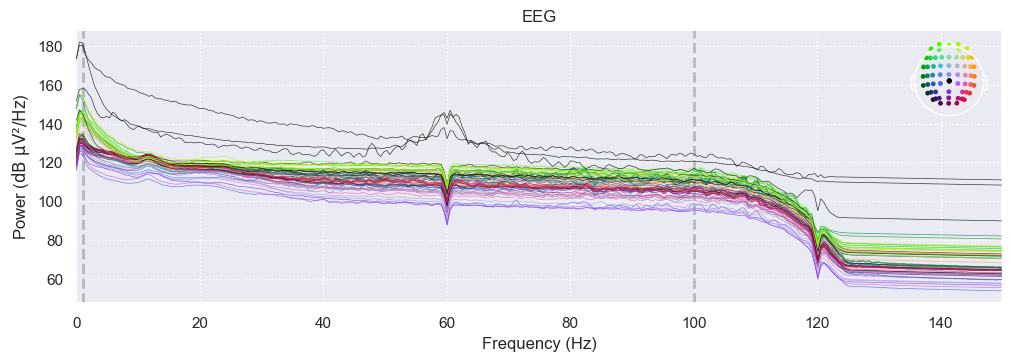

In [ ]:
# # Check PSD
# fig = raw.compute_psd(tmax=np.inf, fmax=250).plot()
# plt.show()

plt.clf()
set_channel_names(raw_filtered,ch_names)

raw_filtered.set_montage('standard_1020', on_missing='warn')
raw_filtered.compute_psd(fmax=150).plot()
plt.show()

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


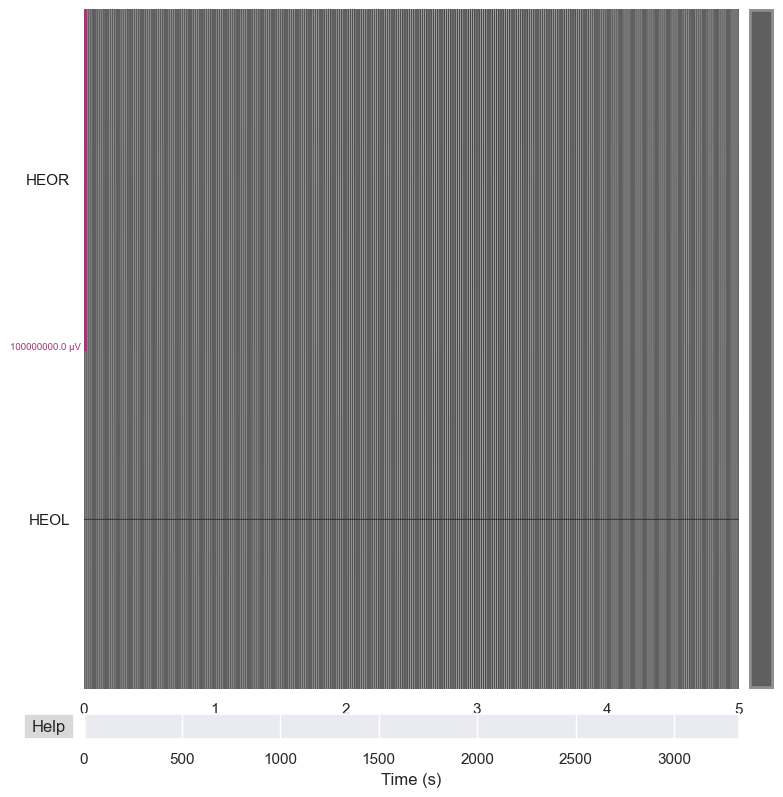

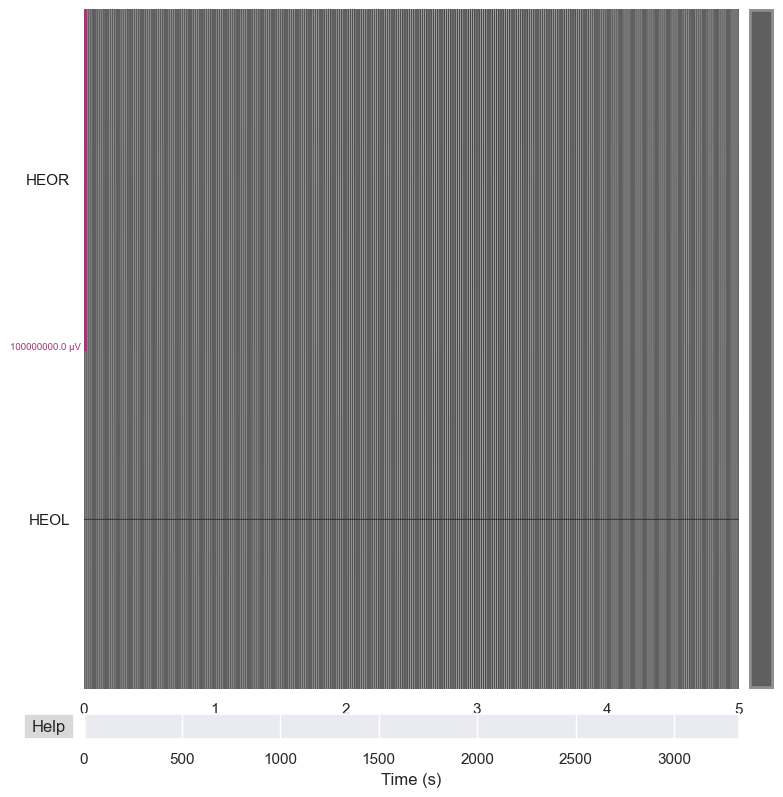

In [ ]:
selected_channels = raw.copy().pick_channels(raw.ch_names[60:62])
selected_channels.plot(duration=5,title="Channels", show=True,scalings = {'eeg': 50})


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


<Figure size 640x480 with 0 Axes>

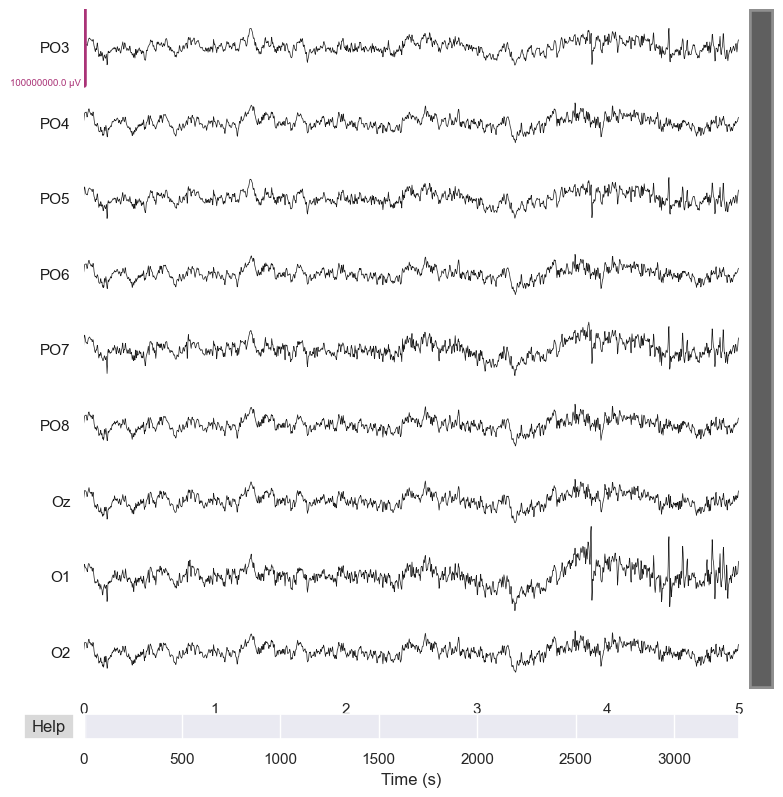

In [ ]:
# Plot the selected channels
selected_channels = raw_filtered.copy().pick_channels(raw.ch_names[50:59])
# selected_channels.plot(duration=5,title="Channels 29 to 31", show=True,scalings = {'eeg': 1e-4})
plt.clf()
selected_channels.plot(duration=5,title="Channels 29 to 31", show=True,scalings = {'eeg': 50})
plt.show()

## **Bad Channel Detection**

bad channels: [30 60 61 62]
Bad channels: ['C5', 'HEOR', 'HEOL', 'VEOU']


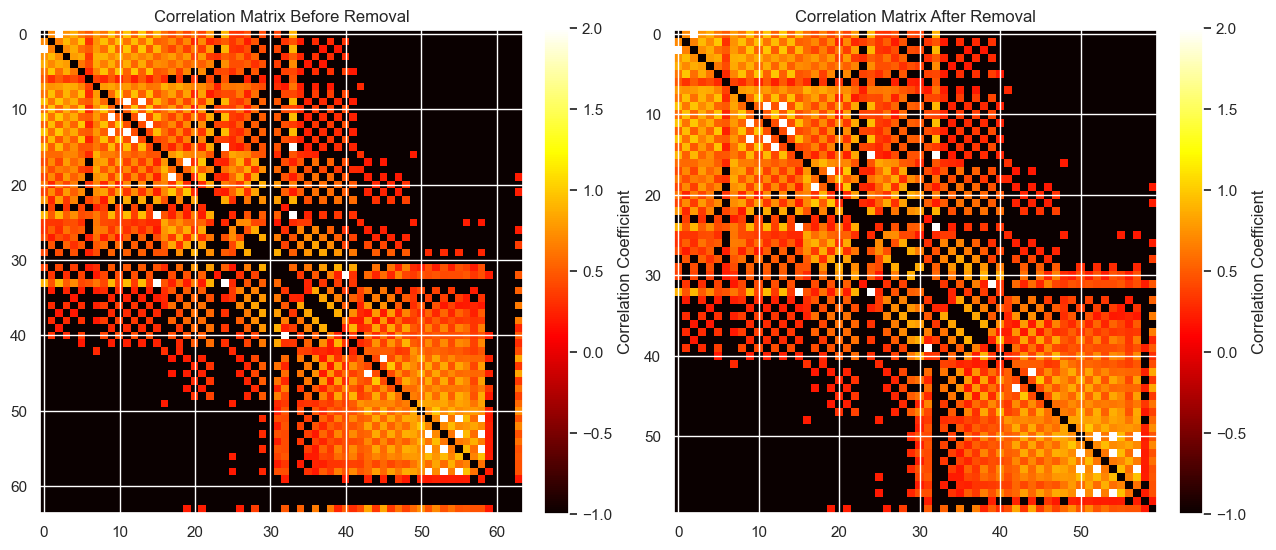

In [ ]:
channel_correlation = plot_channel_correlation(raw_filtered.get_data(), ch_names)

In [ ]:
bad_channels = channel_correlation[1]
bad_channels

['C5', 'HEOR', 'HEOL', 'VEOU']

In [ ]:
bad_channels_2 = detect_bad_channels(raw_filtered.get_data(), ch_names)
print("Bad channels detected:", bad_channels_2)
# print("Bad channels detected:", bad_channels)

Bad channels detected: ['C5', 'HEOR', 'HEOL', 'VEOU']


In [ ]:
raw_removed = raw_filtered.copy()

# parser = argparse.ArgumentParser(description="Process EEG raw data with filtering and bad channel removal.")
# parser.add_argument("raw_file", type=str, help="Path to the raw file to process.")
# parser.add_argument(
#     "--bad_visual", 
#     nargs="+", 
#     default=[], 
#     help="List of bad channels to remove, separated by space (e.g., ECG HEOR HEOL VEOU VEOL)"
# )
# args = parser.parse_args()
# bad_visual = args.bad_visual


bad_visual = ['ECG','HEOR','HEOL','VEOU','VEOL']


In [ ]:
# bad_channels = list(bad_channels)
bad_channels.extend(bad_visual)
bad_channels.extend(bad_channels_2)

raw_removed.info['bads'] = bad_channels
#raw_removed.set_montage('standard_1020', on_missing='warn')
print(raw_removed.info['bads'])

['C5', 'HEOR', 'HEOL', 'VEOU', 'ECG', 'HEOR', 'HEOL', 'VEOU', 'VEOL', 'C5', 'HEOR', 'HEOL', 'VEOU']


/Users/arnavkapur/Desktop/EEG_Speech/Speech_EEG/Preprocessing/utils_clean.py:254: RuntimeWarning: DigMontage is only a subset of info. There are 5 channel positions not present in the DigMontage. The channels missing from the montage are:

['ECG', 'HEOR', 'HEOL', 'VEOU', 'VEOL'].

Consider using inst.rename_channels to match the montage nomenclature, or inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses.
  raw_removed.set_montage('standard_1020', on_missing='warn')


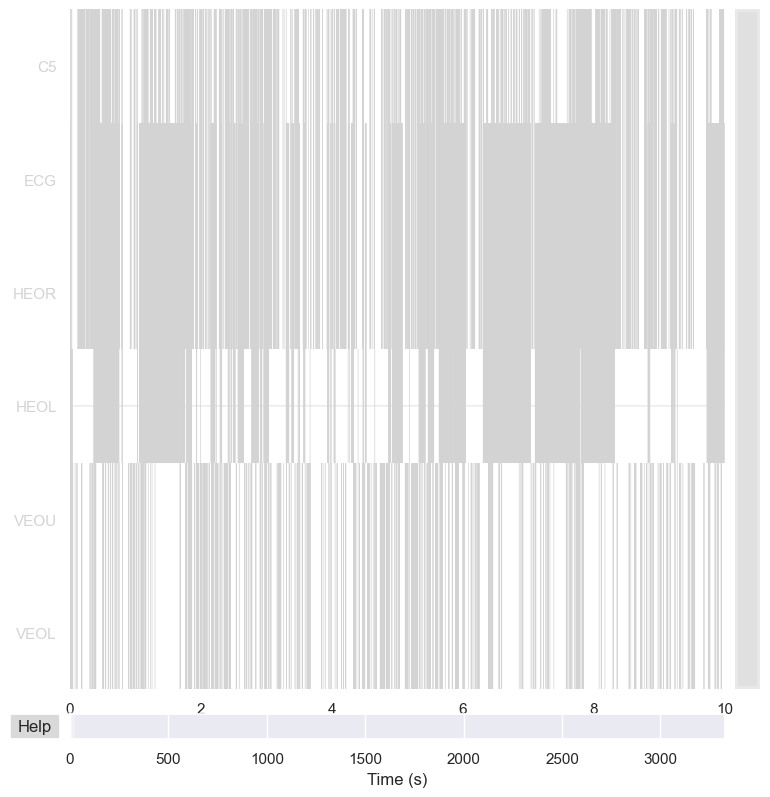

In [ ]:
plot_bads(raw_removed,bad_channels)


ICA Analysis

In [ ]:
ica = mne.preprocessing.ICA(n_components=10, random_state=42, max_iter="auto")
# raw_reconstructed = ica_analysis(raw_removed)


In [ ]:
# plots = ica_plot(raw_removed)  

In [ ]:
raw_removed

<RawArray | 64 x 3328000 (3328.0 s), ~1.59 GB, data loaded>

In [ ]:
ica = mne.preprocessing.ICA(n_components=10, random_state=42, max_iter="auto")

Fitting ICA to data using 58 channels (please be patient, this may take a while)
Selecting by number: 10 components
Fitting ICA took 115.2s.


<Figure size 640x480 with 0 Axes>

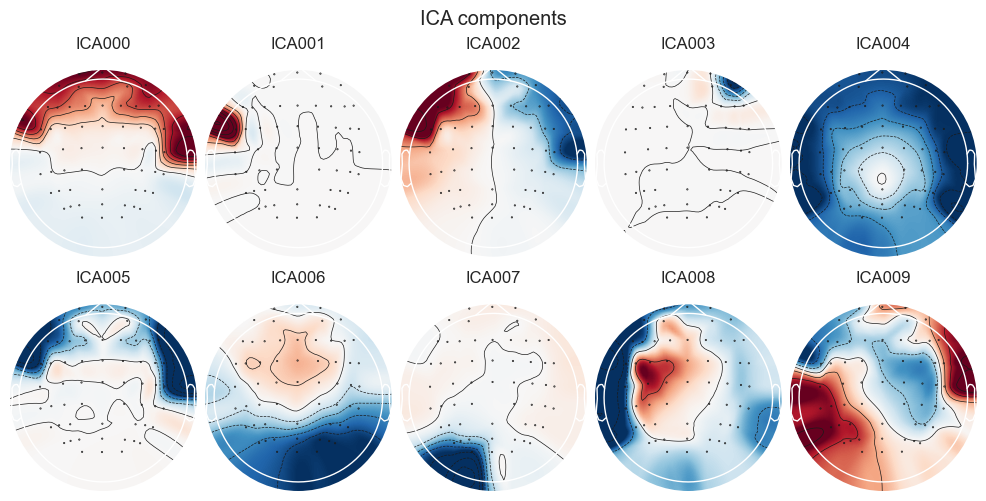

Creating RawArray with float64 data, n_channels=10, n_times=3328000
    Range : 0 ... 3327999 =      0.000 ...  3327.999 secs
Ready.


<Figure size 640x480 with 0 Axes>

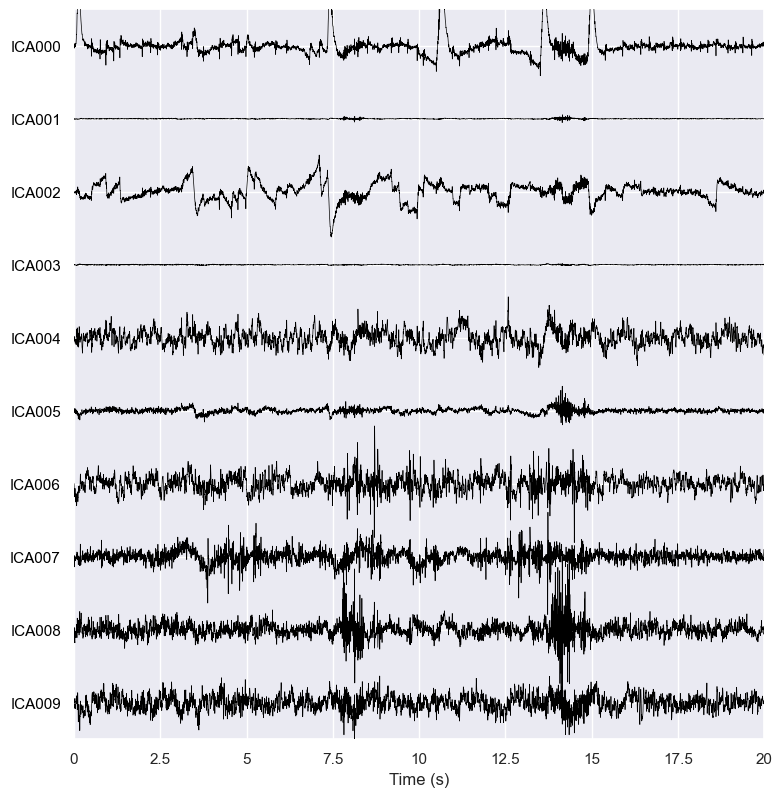

In [ ]:
ica.fit(raw_removed)
plt.clf()
ica.plot_components()
plt.show()

plt.clf()
ica.plot_sources(raw_removed, show_scrollbars=False)
plt.show()

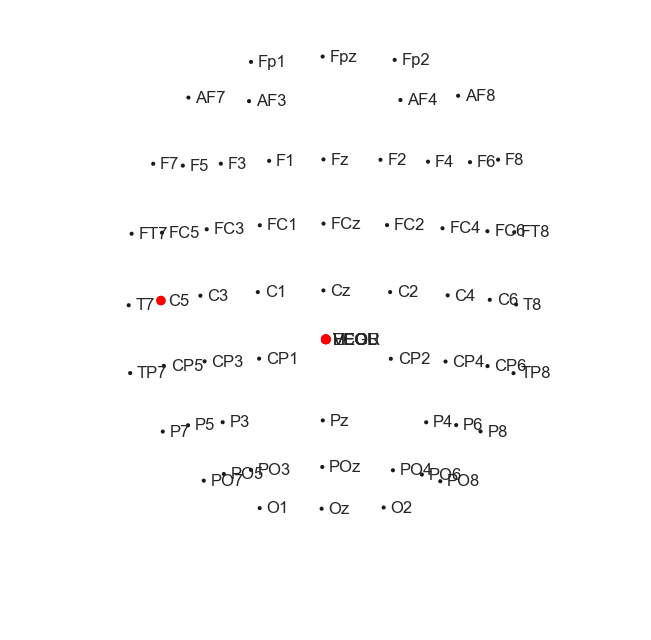

Applying ICA to Raw instance
    Transforming to ICA space (10 components)
    Zeroing out 4 ICA components
    Projecting back using 58 PCA components


<RawArray | 64 x 3328000 (3328.0 s), ~1.59 GB, data loaded>

In [ ]:
# """Select components to remove with ICA """
ica.exclude = [0,1,2,3]  # details on how we picked these are omitted here
# ica.plot_properties(raw_removed, picks=ica.exclude)

raw_removed.plot_sensors(show_names=True)
raw_reconstructed = raw_removed.copy()
ica.apply(raw_reconstructed)


<Figure size 640x480 with 0 Axes>

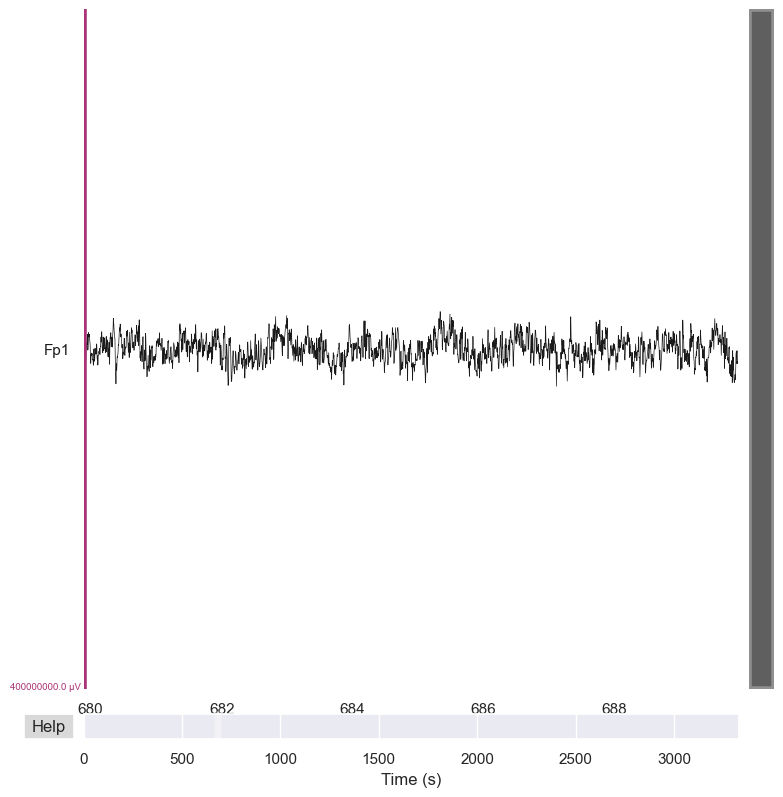

New channel names: ['Fpz', 'Fp1', 'Fp2', 'AF3', 'AF4', 'AF7', 'AF8', 'Fz', 'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'FCz', 'FC1', 'FC2', 'FC3', 'FC4', 'FC5', 'FC6', 'FT7', 'FT8', 'Cz', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'T7', 'T8', 'CP1', 'CP2', 'CP3', 'CP4', 'CP5', 'CP6', 'TP7', 'TP8', 'Pz', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'POz', 'PO3', 'PO4', 'PO5', 'PO6', 'PO7', 'PO8', 'Oz', 'O1', 'O2', 'ECG', 'HEOR', 'HEOL', 'VEOU', 'VEOL']


<Figure size 640x480 with 0 Axes>

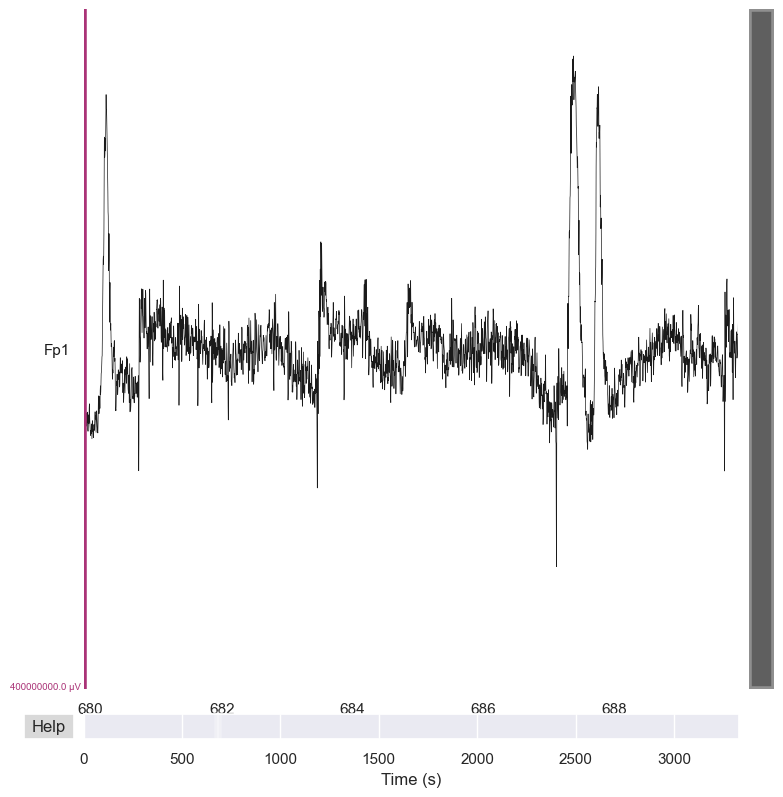

In [ ]:
"compare the data fore eytracking removal before and after ICA"

eeg_start = data[3]['time_stamps'][0]
plt.clf()
raw_reconstructed.plot(start= eeg_start, picks= 'Fp1', n_channels=1, scalings={"eeg": 200})
plt.show()

plt.clf()
set_channel_names(raw_removed, ch_names)
raw_removed.plot(start=eeg_start, picks= 'Fp1', n_channels=1, scalings={"eeg": 200})
plt.show()

## **Data Labelling**

In [ ]:
raw_reconstructed.get_data().shape

(64, 3328000)

Label the Data

In [ ]:
import sys

storage_used_mb = sys.getsizeof(raw_reconstructed) / (1024 * 1024)
print(f"Storage used by raw_reconstructed: {storage_used_mb:.2f} MB")

## Time Offset Synchronization

In [ ]:
data[3]['time_series']

array([[  22769.932,   77179.4  ,  148214.89 , ..., -375000.   ,
          57812.457,  -75986.914],
       [  22772.3  ,   77180.516,  148217.3  , ..., -375000.   ,
          58181.977,  -75991.29 ],
       [  22774.49 ,   77180.11 ,  148219.05 , ..., -375000.   ,
          58730.49 ,  -75992.37 ],
       ...,
       [  14185.029,   78123.58 ,  140245.11 , ..., -375000.   ,
          77398.35 ,  -75674.21 ],
       [  14183.151,   78119.11 ,  140243.45 , ..., -375000.   ,
          77553.07 ,  -75672.336],
       [  14181.273,   78112.67 ,  140241.58 , ..., -375000.   ,
          77788.39 ,  -75672.336]], dtype=float32)

In [ ]:
eeg_stream["time_series"].shape

(3328000, 64)

In [ ]:
eeg_start = data[3]['time_stamps'][0]  # EEG start time, 679.891
marker_start = data[1]['time_stamps'][0]  # Marker start time, 2311465.920826529

time_offset = data[3]['clock_times'][0] - data[1]['clock_times'][0]
aligned_marker_relative = [(ts + time_offset - marker_start + eeg_start) for ts in data[1]['time_stamps']]

eeg_time = data[3]['time_stamps']
aligned_pairs = []
for marker_time in aligned_marker_relative:
    closest_idx = np.argmin(np.abs(np.array(eeg_time- marker_time)))
    aligned_pairs.append((marker_time, data[3]['time_stamps'][closest_idx]))


In [ ]:
print(eeg_stream['time_stamps'][0])
print(marker_stream['time_stamps'][0])
print(eeg_stream['clock_times'][0])
print(marker_stream['clock_times'][0])


679.8911178795346
2311465.920826529
2311455.90225555
2311455.90226175


In [ ]:
eeg_start = data[3]['time_stamps'][0]  # EEG start time
print("EEG START", eeg_start)
marker_start = data[1]['time_stamps'][0]  # Marker start time
time_offset = data[3]['clock_times'][0] - data[1]['clock_times'][0]
print("MARKER START", marker_start) 
print("TIME OFFSET", time_offset)

EEG START 679.8911178795346
MARKER START 2311465.920826529
TIME OFFSET -6.1998143792152405e-06


In [ ]:
print("START WITH DATA")

# Retrieve and print necessary values
eeg_start = data[3]['time_stamps'][0]  # EEG start time
print("EEG START", eeg_start)
marker_start = data[1]['time_stamps'][0]  # Marker start time
time_offset = data[3]['clock_times'][0] - data[1]['clock_times'][0]
print("TIME OFFSET", time_offset)

# Use NumPy arrays for efficiency, avoid copying unnecessarily
marker_times = np.asarray(data[1]['time_stamps'])  # Convert to NumPy array directly
eeg_time = np.asarray(data[3]['time_stamps'])      # Convert to NumPy array directly

# Precompute aligned marker times
aligned_marker_relative = marker_times + time_offset - marker_start + eeg_start

# Use a more memory-efficient method for finding closest indices
# Instead of creating the full difference matrix, iterate over aligned_marker_relative
closest_indices = np.empty(len(aligned_marker_relative), dtype=np.int64)

for i, marker_time in enumerate(aligned_marker_relative):
    closest_indices[i] = np.abs(eeg_time - marker_time).argmin()

# Generate aligned pairs (optional, use generator if possible to avoid memory cost)
aligned_pairs = np.stack((aligned_marker_relative, eeg_time[closest_indices]), axis=1)

print("END ALIGNMENT")

START WITH DATA
EEG START 679.8911178795346
TIME OFFSET -6.1998143792152405e-06
END ALIGNMENT


## Labelling

In [ ]:
df_marker = pd.DataFrame(data[1]['time_series'], aligned_marker_relative,columns=['marker'])
eeg_time_series = raw_reconstructed.get_data()
eeg_time_series = eeg_time_series.T
eeg_timestamps = eeg_stream["time_stamps"]
event_time_series= marker_stream['time_series']
event_time_stamps= aligned_marker_relative

event_time_series_onset = df_marker[df_marker['marker'] == 1].reset_index()
event_time_series_offset = df_marker[df_marker['marker'] == 0].reset_index()
event_time_series_onset['numb'] = range(len(event_time_series_onset))
event_time_series_offset['numb'] = range(len(event_time_series_offset))
print("EVNETTIMESERIES", event_time_series_onset.shape)
print("EVENTTIMESERIESOFFSET", event_time_series_offset.shape)


# diff = np.subtract.outer(c, eeg_timestamps)
# eeg_indices = np.argmin(np.abs(diff), axis=1)
# start = eeg_indices[0] #index at which first event aligns within the EEG 

# find eeg timestamp closest to marker onset
eeg_closest_timestamps = []  

for event_time in event_time_stamps:
    closest_index = np.argmin(np.abs(eeg_timestamps - event_time))
    closest_timestamp = eeg_timestamps[closest_index]  
    eeg_closest_timestamps.append(closest_timestamp)


eeg_indeces = np.array(eeg_closest_timestamps)
# print("EEG_INDICES", eeg_indeces.shape)
# diff = np.subtract.outer(event_time_stamps, eeg_timestamps)
# eeg_indeces = np.argmin(np.abs(diff), axis=1)


labels = np.empty(eeg_timestamps.shape, dtype=int)
labels.fill(900) #Fill with 900 (break)
group_labels = np.copy(labels)
trials = np.copy(labels)

start = eeg_indeces[0]
# Grab the EEG data from first event onwards and turn into dataframe
# eeg_data = eeg_time_series[int(start):, :64]
eeg_data = eeg_time_series[:, :64]

out = pd.DataFrame(eeg_data, columns=ch_names)
print("OUT",out.shape)    


"Define the labels for the 5 sentences"

trial_label = mark['labels']
nan_count = trial_label.isna().sum()
trial_label = trial_label.dropna().astype(int)
print(trial_label.shape)
print(trial_label)  

trial_label.index = range(len(trial_label))
event_time_series_offset['label'] = trial_label.astype(int)
event_time_series_offset = event_time_series_offset[:-1]
event_time_series_onset['label'] = trial_label.astype(int)  
event_time_series_onset = event_time_series_onset[:-1]


# Build the dataset
start_index = eeg_indeces[::2]
end_index = eeg_indeces[1::2]
start_index = start_index[:-1]
end_index = end_index[:-1]
print(start_index.shape, end_index.shape, event_time_series_onset['label'].shape) #(461,) (461,) (461,)



EVNETTIMESERIES (462, 3)
EVENTTIMESERIESOFFSET (462, 3)
OUT (3328000, 64)
(461,)
1      4
2      2
3      1
4      0
5      3
      ..
457    4
458    1
459    3
460    2
461    2
Name: labels, Length: 461, dtype: int64
(461,) (461,) (461,)


In [ ]:
sf = raw.info['sfreq']

durations = end_index - start_index
labels = np.full(len(eeg_timestamps), 900)

print(eeg_timestamps)

for i in range(len(start_index)):
    start_idx = np.where(eeg_timestamps == start_index[i])[0]
    if len(start_idx) == 0:
        print(f"Start index {start_index[i]} not found in eeg_timestamps.")
        continue
    start_idx = start_idx[0]
        
    num_timestamps = int(durations[i] * sf)
    end_idx = min(start_idx + num_timestamps, len(eeg_timestamps))
    labels[start_idx:end_idx] = event_time_series_onset['label'][i]


# df = pd.DataFrame({'time': eeg_timestamps, 'label': labels})


dataset = []
df = pd.concat([pd.DataFrame({'time': eeg_timestamps, 'label': labels}), out], axis=1)
print(df)
dataset.append(df)
dataset


def print_sample_distribution(labels):
    label_count = pd.Series(labels).value_counts().sort_index()

    print("Time sample distribution among different trials:")
    for label, count in label_count.items():
        print(f"Label {label}: {count} time samples")


label_count = df['label'].value_counts()
dataset[0]['label'].value_counts()

[ 679.89111788  679.89211788  679.89311788 ... 4007.8881177  4007.8891177
 4007.8901177 ]
                time  label       Fpz       Fp1       Fp2       AF3       AF4  \
0         679.891118      4  0.008932  0.009298  0.008756  0.006072  0.005285   
1         679.892118      4 -0.563415 -1.783705 -0.521026 -1.487539  1.227660   
2         679.893118      4 -0.890603 -3.388266 -0.807775 -2.392751  2.012931   
3         679.894118      4 -0.825642 -4.618326 -0.713566 -2.365023  2.086851   
4         679.895118      4 -0.373551 -5.297585 -0.260012 -1.441407  1.446213   
...              ...    ...       ...       ...       ...       ...       ...   
3327995  4007.886118    900  0.231508  2.943896  0.593328 -1.808290 -0.915897   
3327996  4007.887118    900  0.335998  3.442305  0.591868 -1.551703 -0.880335   
3327997  4007.888118    900  0.310798  3.049213  0.476036 -1.157623 -0.691488   
3327998  4007.889118    900  0.186677  1.792736  0.268272 -0.620750 -0.377683   
3327999  4007.89011

900    1034647
2       519015
3       453742
0       449540
4       446971
1       424085
Name: label, dtype: int64

In [ ]:
"Delete the breaks from the dataset"
#  using .query() to maintain the order of the columns removing th
dataset[0] = dataset[0].query("label != 900").reset_index(drop=True)

# using this to remove breaks without maining   the order of the columns
# dataset[0] = dataset[0].loc[dataset[0]['label'] != 900].reset_index(drop=True)
dataset[0]['label'].value_counts()

2    519015
3    453742
0    449540
4    446971
1    424085
Name: label, dtype: int64

In [ ]:
# Split the dataset based on the durations into trials
split_datasets = []
start_idx = 0
d =dataset[0]    

for duration in durations:
    end_idx = start_idx + int(duration * sf)
    split_df = d.iloc[start_idx:end_idx].copy()
    split_datasets.append(split_df)
    start_idx = end_idx

# # Verify the splits
# for i, split_df in enumerate(split_datasets):
#     print(f"Split {i}: {split_df.shape}")
# for dataset in split_datasets:
#     print(dataset['label'].value_counts())


In [ ]:
d['time'].iloc[-1] - d['time'].iloc[0]

3295.4009998253855

In [ ]:
# Padding data to max timestamp
max_duration = 0
longest_array = None

for dataset in split_datasets:
    duration = d['time'].iloc[-1] - d['time'].iloc[0]
    if duration > max_duration:
        max_duration = duration
        longest_array = dataset

print("MAX Duration", max_duration)

max_length = max([dataset.shape[0] for dataset in split_datasets])

padded_dataset = []
for dataset in split_datasets:
    num_samples_to_pad = max_length - dataset.shape[0]
    
    if num_samples_to_pad > 0:
        label = d['label'].iloc[0]  
        padding_df = pd.DataFrame(0, index=range(num_samples_to_pad), columns=dataset.columns)
        padding_df['label'] = label 
        padded_dataset.append(pd.concat([dataset, padding_df], ignore_index=True))
    else:
        padded_dataset.append(dataset)

dataset_lengths = [dataset.shape[0] for dataset in padded_dataset]
print(f"Lengths after padding: {set(dataset_lengths)}")  
# for dataset in padded_dataset:
#     print(dataset['label'].value_counts())

dataset_lengths = [dataset.shape[0] for dataset in padded_dataset]

min_length = min(dataset_lengths)
max_length = max(dataset_lengths)

print(f"Minimum length: {min_length}")
print(f"Maximum length: {max_length}")



MAX Duration 3295.4009998253855
Lengths after padding: {7196}
Minimum length: 7196
Maximum length: 7196


In [ ]:
import sys

# Calculate the size of padded_dataset in bytes
size_bytes = sys.getsizeof(padded_dataset)

# Convert bytes to megabytes
size_mb = size_bytes / (1024 * 1024)

# Print the storage used by padded_dataset in MB
print(f"Storage used by padded_dataset: {size_mb} MB")

In [ ]:
# Epoching Data into (n_trials, n_channels, n_samples)
epoch =[]
labels = []
eeg_data_list = []

for dataset in padded_dataset:
    labels.append(dataset['label'].iloc[0]) 
    eeg_data = dataset.drop(columns=['time', 'label']).values.T
    eeg_data_list.append(eeg_data)

labels = np.array(labels)
epoch = [labels] + eeg_data_list

eeg_data_stacked = np.stack(eeg_data_list)
epoch[1:] = [eeg_data_stacked]  

print("Labels shape:", epoch[0].shape) 
print("EEG data shape:", epoch[1].shape)  


Labels shape: (461,)
EEG data shape: (461, 64, 7196)


## Standartization & Clamping


In [ ]:
eeg_epochs_standardized = standartization(epoch[1])
eeg_epochs_standardized.shape

(461, 64, 7196)

In [ ]:
# clamping to 20 times sd. referring to Deffosez et al. 2023
clamp = 20.0

for i in tqdm(range(len(eeg_epochs_standardized)), total=len(eeg_epochs_standardized), desc="Clamping"):
    if isinstance(eeg_epochs_standardized[i], np.ndarray):  # Check if the current item is a NumPy array
        channel_data = eeg_epochs_standardized[i]
        np.clip(channel_data, a_min=-clamp, a_max=clamp, out=channel_data)
        eeg_epochs_standardized[i] = channel_data

python(26559) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Clamping:   0%|          | 0/461 [00:00<?, ?it/s]

In [ ]:
import sys

# Get the size of eeg_epochs_standardized in bytes
size_bytes = sys.getsizeof(eeg_epochs_standardized)

# Convert the size to MB
size_mb = size_bytes / (1024 * 1024)

print(f"The data storage size of eeg_epochs_standardized is approximately {size_mb:.2f} MB")

In [104]:
# Get the underlying data from the raw object
eeg_data = raw.get_data()

# Print the shape of the data
print(f"Shape of EEG data: {eeg_data.shape}")

# Calculate the size in bytes and convert to megabytes (MB)
data_size_bytes = eeg_data.nbytes
data_size_mb = data_size_bytes / (1024 ** 2)

print(f"EEG data size: {data_size_bytes} bytes ({data_size_mb:.2f} MB)")


# Get the underlying data from the reconstructed raw object
eeg_data_reconstructed = raw_reconstructed.get_data()

# Print the shape of the data
print(f"Shape of reconstructed EEG data: {eeg_data_reconstructed.shape}")

# Calculate the size in bytes and convert to megabytes (MB)
data_size_bytes_reconstructed = eeg_data_reconstructed.nbytes
data_size_mb_reconstructed = data_size_bytes_reconstructed / (1024 ** 2)

print(f"Reconstructed EEG data size: {data_size_bytes_reconstructed} bytes ({data_size_mb_reconstructed:.2f} MB)")



import numpy as np

# Calculate the storage size for each dataset in `padded_dataset`
total_size_bytes = 0

for i, dataset in enumerate(padded_dataset):
    size_bytes = dataset.memory_usage(index=True, deep=True).sum()
    total_size_bytes += size_bytes
    print(f"Dataset {i} size: {size_bytes / (1024 ** 2):.2f} MB")

# Convert total size to megabytes (MB)
total_size_mb = total_size_bytes / (1024 ** 2)

print(f"Total size of padded_dataset: {total_size_bytes} bytes ({total_size_mb:.2f} MB)")


import numpy as np

# Calculate total size if it's a list of arrays
total_size_bytes = sum(arr.nbytes for arr in eeg_epochs_standardized if isinstance(arr, np.ndarray))
total_size_mb = total_size_bytes / (1024 ** 2)

print(f"Total size of standardized EEG data: {total_size_bytes} bytes ({total_size_mb:.2f} MB)")




Shape of EEG data: (64, 3328000)
EEG data size: 1703936000 bytes (1625.00 MB)
Shape of reconstructed EEG data: (64, 3328000)
Reconstructed EEG data size: 1703936000 bytes (1625.00 MB)
Dataset 0 size: 3.62 MB
Dataset 1 size: 3.62 MB
Dataset 2 size: 3.62 MB
Dataset 3 size: 3.62 MB
Dataset 4 size: 3.62 MB
Dataset 5 size: 3.62 MB
Dataset 6 size: 3.62 MB
Dataset 7 size: 3.62 MB
Dataset 8 size: 3.62 MB
Dataset 9 size: 3.62 MB
Dataset 10 size: 3.62 MB
Dataset 11 size: 3.62 MB
Dataset 12 size: 3.62 MB
Dataset 13 size: 3.62 MB
Dataset 14 size: 3.62 MB
Dataset 15 size: 3.62 MB
Dataset 16 size: 3.62 MB
Dataset 17 size: 3.62 MB
Dataset 18 size: 3.62 MB
Dataset 19 size: 3.62 MB
Dataset 20 size: 3.62 MB
Dataset 21 size: 3.62 MB
Dataset 22 size: 3.62 MB
Dataset 23 size: 3.62 MB
Dataset 24 size: 3.62 MB
Dataset 25 size: 3.62 MB
Dataset 26 size: 3.62 MB
Dataset 27 size: 3.62 MB
Dataset 28 size: 3.62 MB
Dataset 29 size: 3.62 MB
Dataset 30 size: 3.62 MB
Dataset 31 size: 3.62 MB
Dataset 32 size: 3.62 MB
D

## **Export Data**

In [ ]:
# import os

# data_path = os.path.join(base_path, "DATA")
# folder_path = os.path.join(data_path, 'PREPROCESSED', name)
# if not os.path.exists(folder_path):
#     os.makedirs(folder_path)

# eeg_path = os.path.join(folder_path, 'eeg.npy')
# np.save(eeg_path, eeg_epochs_standardized)
# label_path = os.path.join(folder_path, 'labels.npy')
# np.save(label_path, epoch[0])



KeyboardInterrupt: 

In [ ]:
data = np.load('/Users/arnavkapur/Desktop/EEG_Speech/DATA/PREPROCESSED/S05/data.npy')
data.shape

(749, 64, 7744)